In [14]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Paths
data_dir = 'chest_xray'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')  # We'll merge this into train
test_path = os.path.join(data_dir, 'test')

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(num_output_channels=1), 
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(num_output_channels=1),
])

# 1. Merge train + val folders temporarily
# Load both datasets
merged_train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset_to_merge = datasets.ImageFolder(val_path, transform=train_transform)

# Concatenate them manually
merged_train_dataset.samples.extend(val_dataset_to_merge.samples)
merged_train_dataset.targets.extend(val_dataset_to_merge.targets)

# 2. Stratified split
labels = merged_train_dataset.targets
indices = list(range(len(merged_train_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.15,  # 15% validation split
    stratify=labels,
    random_state=42
)

# 3. Create subsets
train_dataset = Subset(merged_train_dataset, train_idx)
val_dataset = Subset(merged_train_dataset, val_idx)

# 4. Load test data as-is
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# 5. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Print new sizes
print("New dataset sizes:")
print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))
print("Class mapping:", merged_train_dataset.class_to_idx)


New dataset sizes:
Train: 4447 Val: 785 Test: 624
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


Visualization Function

Sample images from training set:


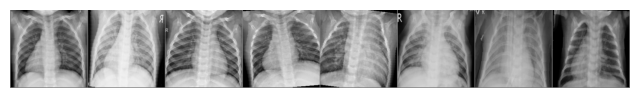

In [15]:
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

# Show some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Sample images from training set:")
imshow(torchvision.utils.make_grid(images[:8]))

resNet model setup

In [17]:
model = models.resnet50(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Modify first conv layer to accept 1 input channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

Loss and optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Training Loop

In [24]:
# Metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 15

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/15], Train Loss: 0.0337, Train Acc: 0.9879, Val Loss: 0.0755, Val Acc: 0.9745
Epoch [2/15], Train Loss: 0.0386, Train Acc: 0.9867, Val Loss: 0.0630, Val Acc: 0.9783
Epoch [3/15], Train Loss: 0.0226, Train Acc: 0.9926, Val Loss: 0.0429, Val Acc: 0.9873
Epoch [4/15], Train Loss: 0.0307, Train Acc: 0.9879, Val Loss: 0.0444, Val Acc: 0.9847
Epoch [5/15], Train Loss: 0.0313, Train Acc: 0.9890, Val Loss: 0.0765, Val Acc: 0.9771
Epoch [6/15], Train Loss: 0.0306, Train Acc: 0.9890, Val Loss: 0.0738, Val Acc: 0.9796
Epoch [7/15], Train Loss: 0.0220, Train Acc: 0.9924, Val Loss: 0.0579, Val Acc: 0.9809
Epoch [8/15], Train Loss: 0.0320, Train Acc: 0.9888, Val Loss: 0.1070, Val Acc: 0.9682
Epoch [9/15], Train Loss: 0.0317, Train Acc: 0.9881, Val Loss: 0.0646, Val Acc: 0.9732
Epoch [10/15], Train Loss: 0.0210, Train Acc: 0.9926, Val Loss: 0.0725, Val Acc: 0.9758
Epoch [11/15], Train Loss: 0.0226, Train Acc: 0.9906, Val Loss: 0.0777, Val Acc: 0.9745
Epoch [12/15], Train Loss: 0.0200, Train 

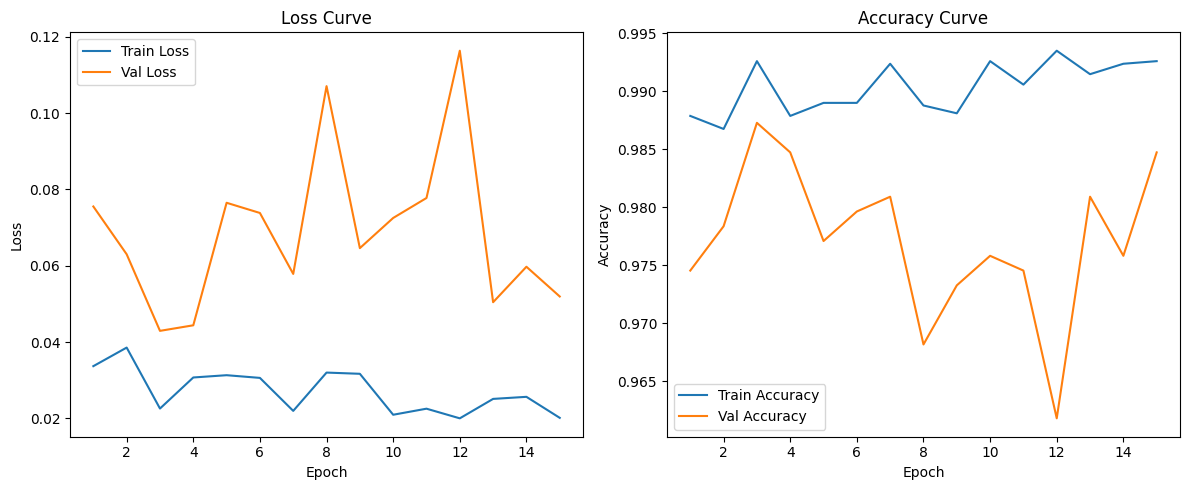

In [25]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


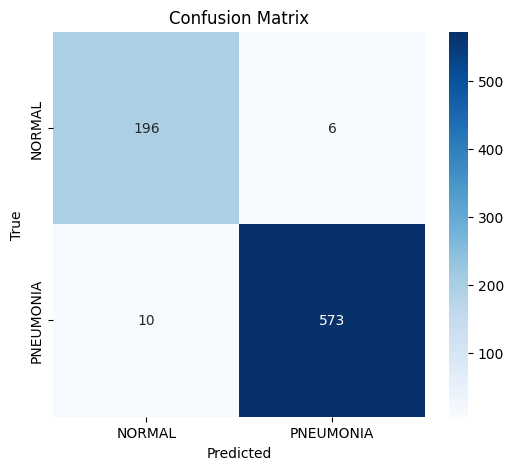

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.97      0.96       202
   PNEUMONIA       0.99      0.98      0.99       583

    accuracy                           0.98       785
   macro avg       0.97      0.98      0.97       785
weighted avg       0.98      0.98      0.98       785



In [27]:
# =============================
# ✅ Confusion Matrix & Classification Report
# =============================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names from dataset
try:
    class_names = train_loader.dataset.dataset.classes  # for Subset
except AttributeError:
    class_names = train_loader.dataset.classes  # for ImageFolder

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [28]:
torch.save(model.state_dict(), "resnet50_chestxray.pth")
print("Model saved as resnet50_chestxray.pth")

Model saved as resnet50_chestxray.pth


In [12]:
!nvidia-smi


Wed May 14 19:01:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:20:00.0 Off |                  N/A |
| 31%   49C    P2             91W /  250W |   10053MiB /  11264MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----